# A very simple example of star/galaxy separation

### First set up some `matplotlib` defaults

In [135]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (13, 8)

### Next import modules for use later

In [2]:
import numpy
import lsst.daf.persistence as daf_persistence
import lsst.afw.geom as afw_geom

/opt/lsst/software/stack/python/miniconda3-4.5.4/envs/lsst-scipipe-10a4fa6/lib/python3.6/importlib/_bootstrap.py:205: FutureWarning: pybind11-bound class 'lsst.sphgeom.box.Box' is using an old-style placement-new '__setstate__' which has been deprecated. See the upgrade guide in pybind11's docs. This message is only visible when compiled in debug mode.
  return f(*args, **kwds)
/opt/lsst/software/stack/python/miniconda3-4.5.4/envs/lsst-scipipe-10a4fa6/lib/python3.6/importlib/_bootstrap.py:205: FutureWarning: pybind11-bound class 'lsst.sphgeom.circle.Circle' is using an old-style placement-new '__setstate__' which has been deprecated. See the upgrade guide in pybind11's docs. This message is only visible when compiled in debug mode.
  return f(*args, **kwds)
/opt/lsst/software/stack/python/miniconda3-4.5.4/envs/lsst-scipipe-10a4fa6/lib/python3.6/importlib/_bootstrap.py:205: FutureWarning: pybind11-bound class 'lsst.sphgeom.convexPolygon.ConvexPolygon' is using an old-style placement-new

### Define a utility function for use later

This function is a very simple image display tool.  It will plot a sub-region if you want and will overlay sources if you pass a catalog.

In [209]:
def overlay_masks(exposure, bbox=None, sources=None):
    masked_image = exposure.getMaskedImage()
    if bbox is not None:
        masked_image = masked_image.Factory(masked_image, bbox)
    (img, mask, var) = masked_image.getArrays()
#    plt.imshow(numpy.log10(img), interpolation='nearest', cmap='gray')
#    plt.imshow(numpy.log10(img-2*img.min()), interpolation='nearest', cmap='gray')
    plt.imshow(numpy.log10(img-1*img.min()), interpolation='nearest', cmap='gray')
    plt.imshow(mask, interpolation='nearest', cmap='Blues', alpha=0.5)
    if sources is not None:
        testbox = afw_geom.Box2D(bbox) # convert to a floating point box
        for source in sources:
            if testbox.contains(source.getCentroid()):
                # Need to account for difference in pixel indexing between matplotlib and stack
                plt.scatter(source.getX()-testbox.getMinX()-0.5, source.getY()-testbox.getMinY()-0.5, 
                            marker='+', c='r', s = 80) #, alpha=0.5)
    plt.show()

### Get some data
This is a very small sample of DECam data that has already been reduced by the LSST stack.  It is a valid butler repository, so we can use standard LSST tools to interact with it.

In [4]:
!if ! [ -d singlechip_sample ]; then curl -O https://lsst-web.ncsa.illinois.edu/~krughoff/data/singlechip.tar.gz ; tar zxvf singlechip.tar.gz; fi

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  107M  100  107M    0     0  38.1M      0  0:00:02  0:00:02 --:--:-- 38.1M
singlechip_sample/
singlechip_sample/0410877/
singlechip_sample/0410877/metadata/
singlechip_sample/0410877/metadata/metadata-0410877_28.boost
singlechip_sample/0410877/icSrc/
singlechip_sample/0410877/icSrc/icSrc-0410877_28.fits
singlechip_sample/0410877/calexp/
singlechip_sample/0410877/calexp/calexp-0410877_28.fits
singlechip_sample/0410877/bkgd/
singlechip_sample/0410877/bkgd/bkgd-0410877_28.fits
singlechip_sample/0410877/postISR/
singlechip_sample/0410877/postISR/postISR-0410877_28.fits
singlechip_sample/0410877/src/
singlechip_sample/0410877/src/src-0410877_28.fits
singlechip_sample/schema/
singlechip_sample/schema/src.fits
singlechip_sample/schema/icSrc.fits
singlechip_sample/_mapper
singlechip_sample/config/
singlechip_sample/config/processCcd.p

### Now we can make a butler
The `Butler` is the data abstraction layer for our stack.  Simply instantiate with a path to a valid repository.  Then you can ask for data by type and a set of unique identifiers.  In this case, I'm getting a calibrated exposure, or `calexp`.

In [5]:
butler = daf_persistence.Butler('singlechip_sample')
exp = butler.get('calexp', visit=410877, ccd=28, filter='r')

### Now let's do something with the exposure
First we construct a bounding box for a subregion in the image.  Then get a source catalog using the `Butler`.  Finally, use the utility function above to plot the image, masks, and source.

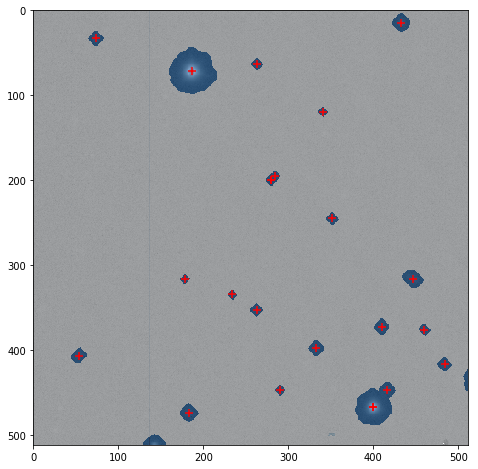

In [210]:
#bbox = afw_geom.Box2I(afw_geom.Point2I(1200, 1200), afw_geom.Extent2I(600,600))
bbox = afw_geom.Box2I(afw_geom.Point2I(1024, 1024), afw_geom.Extent2I(512,512))
sources = butler.get('src', visit=410877, ccd=28, filter='r')
overlay_masks(exp, bbox=bbox, sources=sources)

### Let's do a simple analysis
First calculate the ratio of the model flux to the PSF flux.  This is basically a measure of how much the source looks like a point source.

In [181]:
psf_flux = sources.getPsfFlux()
model_flux = sources.getModelFlux()
flux_ratio = model_flux/psf_flux    # sources.getModelFlux()/sources.getPsfFlux()
psf_flux = numpy.array(psf_flux)
flux_ratio = numpy.array(flux_ratio)

The stack provides a measurement for extendedness as well.  Separate stars from galaxies using this value.

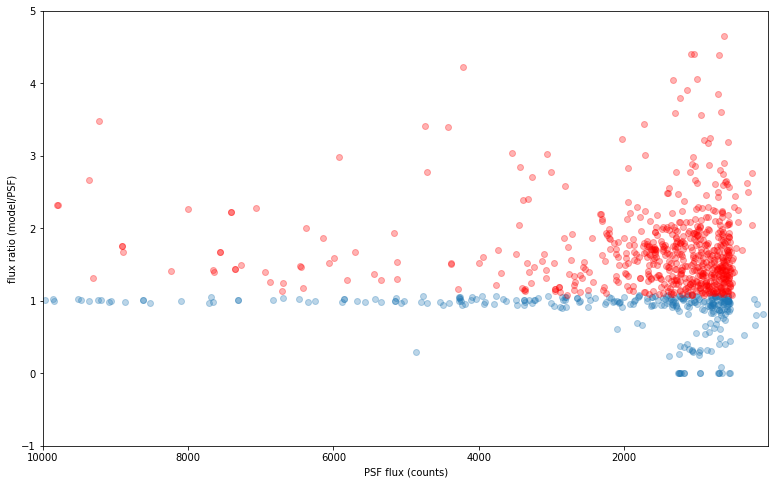

In [182]:
extend = sources.get('base_ClassificationExtendedness_value')
stars = numpy.where(extend==0.0)[0]
galaxies = numpy.where(extend>0.)[0]
plt.scatter(psf_flux[stars], flux_ratio[stars], alpha=0.3)
plt.scatter(psf_flux[galaxies], flux_ratio[galaxies], c='r', alpha=0.3)
plt.xlim(10000, 10)
plt.ylim(-1, 5)
plt.xlabel('PSF flux (counts)')
plt.ylabel('flux ratio (model/PSF)')
plt.show()

Notice how all points above a certain threshold are red.  This simply shows that the default star/galaxy separator in this reduction is a cut in the model flux/PSF flux ratio.

**Now look at the star/galaxy separation with magnitudes instead of flux**

In [183]:
exp_calib = exp.getCalib()
psf_mag = exp_calib.getMagnitude(psf_flux)

# There are some NaN and negative flux values in the model flux array. Filter those:
badmodel = (numpy.isnan(model_flux)) | (model_flux < 0.01)
model_mag = 0.0*psf_mag + 30.0 # set "bad" measurements to mag = 30.0
model_mag[~badmodel] = exp_calib.getMagnitude(model_flux[~badmodel])

magdiff = psf_mag - model_mag

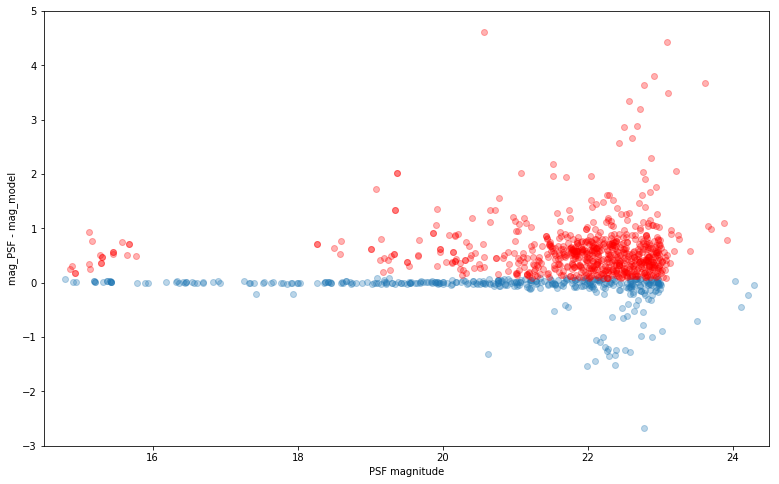

In [184]:
plt.scatter(psf_mag[stars], magdiff[stars], alpha=0.3)
plt.scatter(psf_mag[galaxies], magdiff[galaxies], c='r', alpha=0.3)

plt.xlim(14.5, 24.5)
plt.ylim(-3, 5)
plt.xlabel('PSF magnitude')
plt.ylabel('mag_PSF - mag_model')
plt.show()

You can see that bright, saturated objects get mis-classified as extended. Also, galaxies begin to outnumber stars at ~22nd magnitude.

**Make separate overlays of the stars and galaxies on the image:**

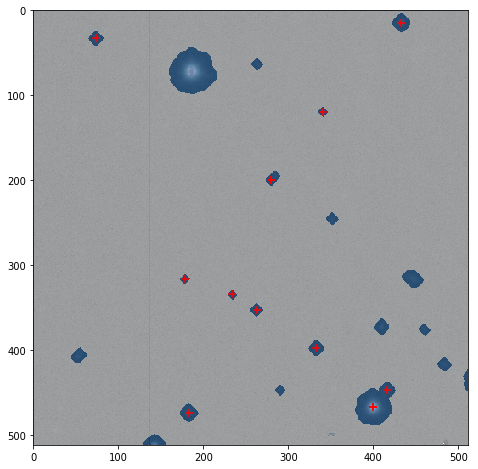

In [211]:
# STARS:
overlay_masks(exp, bbox=bbox, sources=sources[extend==0.0])

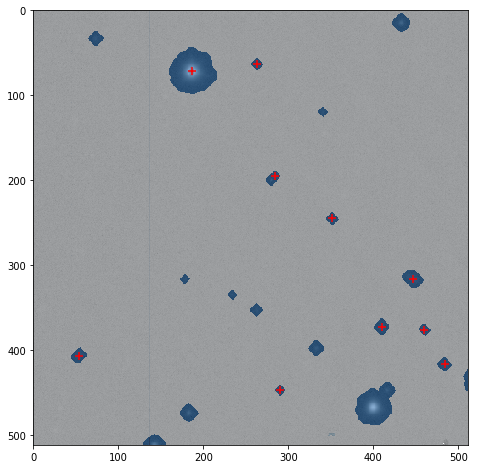

In [212]:
# GALAXIES:
overlay_masks(exp, bbox=bbox, sources=sources[extend > 0.0])